FACULTAD DE INGENIERÍA
APRENDIZAJE AUTOMATICO
PROFESOR: FRANCISCO JOSÉ MERCADO
ESTUDIANTE: JONATHAN GIRALDO DIAZ ORTEGA
PROYECTO: Predicción de depresión en estudiantes: Análisis de factores demográficos, académicos y de estilo de vida.

## Importación de librerias

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Cargando data set

In [69]:
df = pd.read_csv('Data\student_depression_dataset.csv', sep=',')
#df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name']
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\JonathanGiraldoDiazO\AppData\Local\Temp\ipykernel_50476\2699448579.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('Data\student_depression_dataset.csv', sep=',')


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [70]:
df.tail()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1
27900,140699,Male,27.0,Patna,Student,4.0,0.0,9.24,1.0,0.0,'Less than 5 hours',Healthy,BCA,Yes,2.0,3.0,Yes,1


### Verificación de tipo de variables

In [71]:
df.dtypes

id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family History of Mental Illness          object
Depression                                 int64
dtype: object

In [72]:
print(df.isnull().sum())

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [73]:
# Aplicar one-hot encoding a las columnas categoricas yes/no
df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
df['Family History of Mental Illness'] = df['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

In [74]:
import re

def convertir_duracion(s):
    # Buscar dos números (rango tipo '5-6 hours')
    rango = re.findall(r'(\d+)-(\d+)', s)
    if rango:
        n1, n2 = map(int, rango[0])
        return (n1 + n2) / 2

    # Buscar un solo número
    num = re.search(r'(\d+)', s)
    if num:
        n = int(num.group(1))
        if 'less' in s.lower():
            return n - 0.5  # Ej: 'Less than 5' => 4.5
        elif 'more' in s.lower():
            return n + 0.5  # Ej: 'More than 8' => 8.5
        else:
            return float(n)  # Por si acaso hay algo como '5 hours' exacto

    return None  # Por si no se puede interpretar

# Aplicar la función
df['Sleep Duration'] = df['Sleep Duration'].apply(convertir_duracion)



In [75]:
# Diccionario de mapeo
mapeo_dietario = {
    'Healthy': 3,
    'Moderate': 2,
    'Unhealthy': 1
}

# Aplicar el mapeo
df['Dietary Habits'] = df['Dietary Habits'].map(mapeo_dietario)

In [76]:
# remplazamos valores nulos en la columna categorica Dietary Habits con la moda
df['Dietary Habits'] = df['Dietary Habits'].fillna(df['Dietary Habits'].mode()[0])
# remplazamos valores nulos en la columna categorica Sleep Duration  con la moda
df['Sleep Duration'] = df['Sleep Duration'].fillna(df['Sleep Duration'].mode()[0])

### Análisis estadistico

In [77]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Work/Study Hours,Family History of Mental Illness,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,6.377961,1.904018,0.632809,7.156984,0.483961,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,1.590760,0.797014,0.482048,3.707642,0.499752,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.500000,1.000000,0.000000,4.000000,0.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,5.500000,2.000000,1.000000,8.000000,0.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,7.500000,3.000000,1.000000,10.000000,1.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,8.500000,3.000000,1.000000,12.000000,1.000000,1.000000


### Identificando y tratando datos atipicos/outlayers

In [50]:
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

df_transformado = df[~(
                        (df.select_dtypes(include='number') < (Q1 - IQR*1.5))
                        |
                        (df.select_dtypes(include='number') > (Q3 + IQR*1.5))
                       ).any(axis=1)]



In [78]:
print(df_transformado.shape)

(27878, 18)


### Matriz de correlación

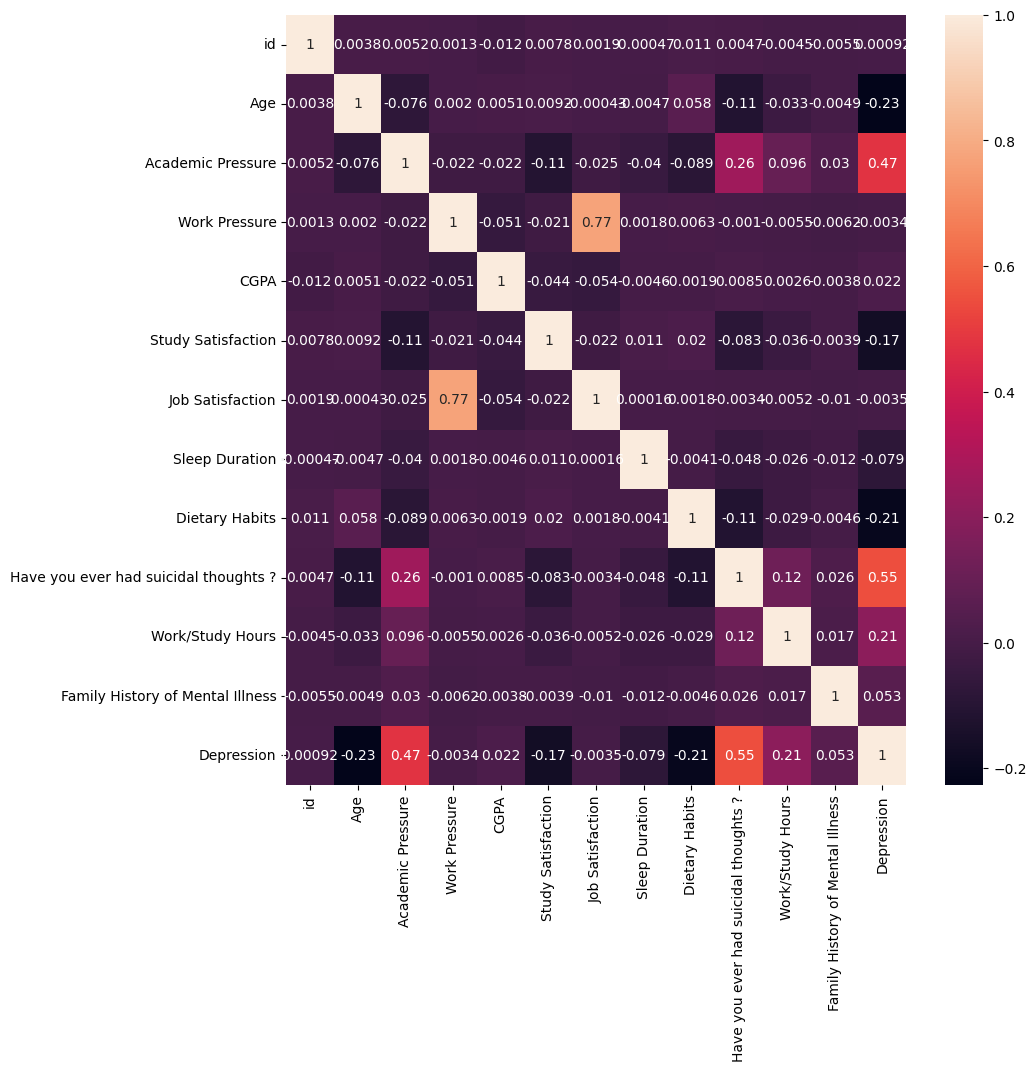

In [80]:
matriz_correlacion = df.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(matriz_correlacion, annot=True)
plt.show()

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


In [54]:
# Selección de variables X e y
cols_x = [
    'Age',
    'Academic Pressure',
    'Work Pressure',
    'CGPA',
    'Study Satisfaction',
    'Job Satisfaction',
    'Sleep Duration',
    'Dietary Habits',
    'Have you ever had suicidal thoughts ?',
    'Work/Study Hours',
    'Family History of Mental Illness'
]

# Filtrar solo columnas requeridas
df_model = df_transformado[cols_x + ['Depression']].copy()

# Convertir a numérico las variables categóricas
# Verificamos si están como texto y las mapeamos
if df_model['Have you ever had suicidal thoughts ?'].dtype == 'object':
    df_model['Have you ever had suicidal thoughts ?'] = df_model['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})

if df_model['Family History of Mental Illness'].dtype == 'object':
    df_model['Family History of Mental Illness'] = df_model['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

# En caso de que Sleep Duration y Dietary Habits no sean numéricos
if df_model['Sleep Duration'].dtype == 'object':
    df_model = pd.get_dummies(df_model, columns=['Sleep Duration'])

if df_model['Dietary Habits'].dtype == 'object':
    df_model = pd.get_dummies(df_model, columns=['Dietary Habits'])

# Separar X e y
X = df_model.drop(columns=['Depression'])
y = df_model['Depression']

# Normalizar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)


## Regresión logistica

Accuracy: 0.82
F1 Score: 0.85
ROC AUC: 0.81
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2898
           1       0.83      0.88      0.85      4072

    accuracy                           0.82      6970
   macro avg       0.82      0.81      0.82      6970
weighted avg       0.82      0.82      0.82      6970



c:\Users\JonathanGiraldoDiazO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


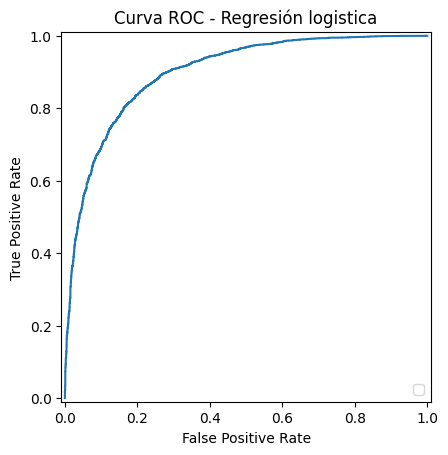

In [55]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log, zero_division=0):.2f}")
try:
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_log):.2f}")
except ValueError:
    print("ROC AUC: No definido (una sola clase en test)")
print(classification_report(y_test, y_pred_log, zero_division=0))



from sklearn.metrics import roc_curve, RocCurveDisplay
# Curva ROC
if hasattr(log_model, "predict_proba"):
    y_proba = log_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("Curva ROC - Regresión logistica")
    plt.show()


## Arbol de decisión

Accuracy: 0.75
F1 Score: 0.78
ROC AUC: 0.74
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      2898
           1       0.78      0.79      0.78      4072

    accuracy                           0.75      6970
   macro avg       0.74      0.74      0.74      6970
weighted avg       0.75      0.75      0.75      6970



c:\Users\JonathanGiraldoDiazO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


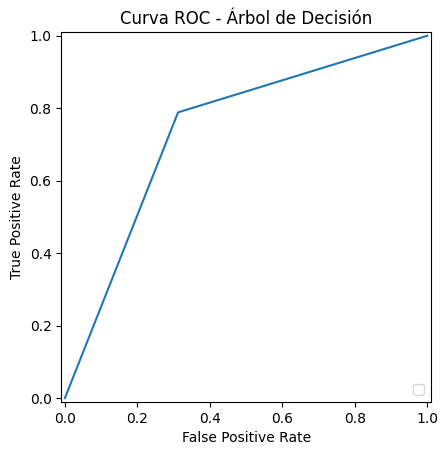

In [56]:
from sklearn.tree import DecisionTreeClassifier, plot_tree


tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_tree, zero_division=0):.2f}")
try:
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_tree):.2f}")
except ValueError:
    print("ROC AUC: No definido (una sola clase en test)")
print(classification_report(y_test, y_pred_tree, zero_division=0))


# Curva ROC 
if hasattr(tree_model, "predict_proba") and len(np.unique(y_test)) == 2:
    y_proba_tree = tree_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_tree)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("Curva ROC - Árbol de Decisión")
    plt.show()




## Random Forest

=== Random Forest ===
Accuracy: 0.82
F1 Score: 0.85
ROC AUC: 0.81
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      2898
           1       0.83      0.86      0.85      4072

    accuracy                           0.82      6970
   macro avg       0.81      0.81      0.81      6970
weighted avg       0.82      0.82      0.82      6970



c:\Users\JonathanGiraldoDiazO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


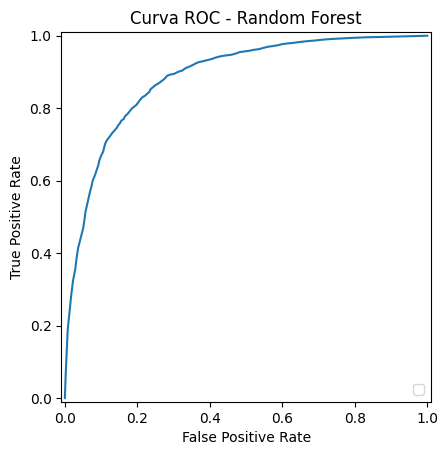

In [57]:
forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

print("=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_forest):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_forest, zero_division=0):.2f}")
try:
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_forest):.2f}")
except ValueError:
    print("ROC AUC: No definido (una sola clase en test)")
print(classification_report(y_test, y_pred_forest, zero_division=0))


# Curva ROC
if hasattr(forest_model, "predict_proba") and len(np.unique(y_test)) == 2:
    y_proba_forest = forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_forest)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("Curva ROC - Random Forest")
    plt.show()
